参考链接：https://scikit-learn.org/stable/modules/sgd.html

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html

Stochastic Gradient Descent (SGD) is a simple yet very efficient approach to fitting linear classifiers and regressors under convex loss functions such as (linear) Support Vector Machines and Logistic Regression. Even though SGD has been around in the machine learning community for a long time, it has received a considerable amount of attention just recently in the context of large-scale learning.

SGD has been successfully applied to large-scale and sparse machine learning problems often encountered in text classification and natural language processing. Given that the data is sparse, the classifiers in this module easily scale to problems with more than 10^5 training examples and more than 10^5 features.

Strictly speaking, SGD is merely an optimization technique and does not correspond to a specific family of machine learning models. It is only a way to train a model. Often, an instance of SGDClassifier or SGDRegressor will have an equivalent estimator in the scikit-learn API, potentially using a different optimization technique. For example, using SGDClassifier(loss='log_loss') results in logistic regression, i.e. a model equivalent to LogisticRegression which is fitted via SGD instead of being fitted by one of the other solvers in LogisticRegression. Similarly, SGDRegressor(loss='squared_error', penalty='l2') and Ridge solve the same optimization problem, via different means.

The advantages of Stochastic Gradient Descent are:

Efficiency.

Ease of implementation (lots of opportunities for code tuning).

The disadvantages of Stochastic Gradient Descent include:

SGD requires a number of hyperparameters such as the regularization parameter and the number of iterations.

SGD is sensitive to feature scaling.

困难点： SGD默认支持单个输出，就是y里面只能有一个值。但是这个项目我们有多个值，可以利用MultiOutputClassifier来整合这些单个的回归。
参考链接：https://datascience.stackexchange.com/questions/87135/valueerror-y-should-be-a-1d-array-got-an-array-of-shape-1045-5-instead#:~:text=Your%20y%20values%20%28i.e.%20the%20values%20that%20you,want%20to%20predict%20with%20the%20Naive%20Bayes%20model.

**导入基础包**

In [8]:
#packages
import pandas as pd
import numpy as np

from pylab import plt
plt.style.use('seaborn')
%matplotlib inline

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

**读取数据**

In [9]:
df = pd.read_csv('data_features_Order.csv') 

In [10]:
df.head()

,Unnamed: 0,Sample ID,Sampling month average,Sampling month,SRTd,COD,NH4N,TP,Unclassified,Burkholderiales,...,Syntrophorhabdales,Bradymonadales,Solibacterales,Methylacidiphilales,UASB-TL25,Calditrichales,Reyranellales,Dongiales,Chthonomonadales,Candidatus Yanofskybacteria
0,0,SAKR1,18.0,55.0,12.0,771.97,61.4,7.2,8.265625,23.570312,...,0.000000,0.042969,0.027344,0.136719,0.058594,0.0,0.109375,0.046875,0.0,0.0
1,1,SAKR2,18.0,55.0,12.0,771.97,61.4,7.2,8.484375,18.730469,...,0.007812,0.054688,0.054688,0.152344,0.019531,0.0,0.093750,0.093750,0.0,0.0
2,2,SAKR3,18.0,55.0,12.0,771.97,61.4,7.2,8.308594,19.378906,...,0.000000,0.023438,0.031250,0.132812,0.015625,0.0,0.070312,0.058594,0.0,0.0
3,3,SAKR4,18.0,55.0,12.0,771.97,61.4,7.2,8.394531,22.824219,...,0.003906,0.035156,0.054688,0.179688,0.035156,0.0,0.109375,0.093750,0.0,0.0
4,4,SAKR5,18.0,55.0,12.0,771.97,61.4,7.2,8.585938,18.863281,...,0.000000,0.023438,0.039062,0.105469,0.011719,0.0,0.070312,0.082031,0.0,0.0


In [11]:
df.shape

(1186, 179)

In [12]:
df.columns

Index(['Unnamed: 0', 'Sample ID', 'Sampling month average', 'Sampling month',
       'SRTd', 'COD', 'NH4N', 'TP', 'Unclassified', 'Burkholderiales',
       ...
       'Syntrophorhabdales', 'Bradymonadales', 'Solibacterales',
       'Methylacidiphilales', 'UASB-TL25', 'Calditrichales', 'Reyranellales',
       'Dongiales', 'Chthonomonadales', 'Candidatus Yanofskybacteria'],
      dtype='object', length=179)

In [13]:
features = ['Sampling month average', 'Sampling month','SRTd', 'COD', 'NH4N', 'TP']
targets = df.columns.to_numpy()
targets = targets[8:]

**简单的EDA**

In [14]:
df.isnull().sum()

Unnamed: 0                       0
Sample ID                        0
Sampling month average         132
Sampling month                  23
SRTd                           342
                              ... 
Calditrichales                   0
Reyranellales                    0
Dongiales                        0
Chthonomonadales                 0
Candidatus Yanofskybacteria      0
Length: 179, dtype: int64

我们看到预测目标里面没有NA， 不过features里面有NA. 

部分features的空值较多，还不能直接drop. 

考虑给空值部分填充均值。

分拆数据

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
# Splitting the datasets into training and testing data.
train_data, test_data = train_test_split(df, train_size=0.8, test_size=0.2, shuffle=False)

# Output the train and test data size
print(f"Train and Test Size {len(train_data)}, {len(test_data)}")

Train and Test Size 948, 238


在train data 部分曲均值

In [17]:
train_data[features].mean()

Sampling month average     23.154379
Sampling month            115.381081
SRTd                       15.258321
COD                       430.108594
NH4N                       26.645109
TP                          6.274391
dtype: float64

用这部均值填充NA数据

In [18]:
df['Sampling month average'].fillna(23.154379, inplace = True)
df['Sampling month'].fillna(115.381081, inplace = True)
df['SRTd'].fillna(15.258321, inplace = True)
df['COD'].fillna(430.108594, inplace = True)
df['NH4N'].fillna(26.645109, inplace = True)
df['TP'].fillna(6.274391, inplace = True)

检查NA

In [19]:
df.isnull().sum()

Unnamed: 0                     0
Sample ID                      0
Sampling month average         0
Sampling month                 0
SRTd                           0
                              ..
Calditrichales                 0
Reyranellales                  0
Dongiales                      0
Chthonomonadales               0
Candidatus Yanofskybacteria    0
Length: 179, dtype: int64

重定义训练和测试集

In [20]:
# Splitting the datasets into training and testing data.
train_data, test_data = train_test_split(df, train_size=0.8, test_size=0.2, shuffle=False)

# Output the train and test data size
print(f"Train and Test Size {len(train_data)}, {len(test_data)}")

Train and Test Size 948, 238


**建模**

In [21]:
from sklearn import linear_model 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge #导入岭回归模型
from sklearn.linear_model import SGDRegressor
from sklearn.multioutput import MultiOutputRegressor

In [22]:
X_train = train_data[features]
y_train = train_data[targets]
X_test = test_data[features]
y_test = test_data[targets]

In [23]:
sgd =  SGDRegressor(penalty="elasticnet", alpha=0.01, l1_ratio=0.25, tol=1e-4)
msgd = MultiOutputRegressor(sgd)

In [24]:
model = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', msgd)
])

训练模型

In [25]:
model.fit(X_train, y_train)
print(f'R^2 Train: {model.score(X_train, y_train):0.4}')

R^2 Train: 0.06897


利用训练好的模型做测试

In [26]:
y_preds = model.predict(X_test)

In [27]:
y_preds

array([[5.41596111e+00, 2.15117071e+01, 1.91389254e+01, ...,
        1.37215003e-01, 3.40345032e-03, 5.24147458e-03],
       [5.67403683e+00, 2.18429813e+01, 1.99874340e+01, ...,
        6.58116691e-02, 3.40345032e-03, 5.24147458e-03],
       [5.67403683e+00, 2.18429813e+01, 1.99874340e+01, ...,
        6.58116691e-02, 3.40345032e-03, 5.24147458e-03],
       ...,
       [4.77793755e+00, 2.27867243e+01, 1.86310532e+01, ...,
        1.09450617e-01, 3.40345032e-03, 5.24147458e-03],
       [4.77793755e+00, 2.27867243e+01, 1.86310532e+01, ...,
        1.09450617e-01, 3.40345032e-03, 5.24147458e-03],
       [4.77793755e+00, 2.27867243e+01, 1.86310532e+01, ...,
        1.09450617e-01, 3.40345032e-03, 5.24147458e-03]])

**结果可视化**

展示第一个ID的预测结果。

In [28]:
y_preds[0]

array([5.41596111e+00, 2.15117071e+01, 1.91389254e+01, 1.65104845e+00,
       7.61274794e-01, 1.10776621e+00, 4.19232185e-01, 3.37665835e+00,
       5.92942244e-01, 1.44741528e+00, 1.80094128e+00, 1.85973708e-01,
       8.38838567e-01, 2.63572000e-01, 3.87871464e+00, 2.77064053e-01,
       2.30599238e+00, 1.71846259e-01, 3.63434234e-01, 1.97714983e+00,
       7.99329883e-01, 5.67065861e-01, 3.12118350e+00, 3.82021747e-01,
       2.43402225e+00, 3.75686828e-01, 5.71664788e-02, 7.88205138e-02,
       1.86848568e-01, 4.15267321e-01, 5.61332036e-02, 9.06273728e-01,
       9.27698776e-02, 4.38219621e-01, 1.98970335e-01, 3.14891863e-01,
       7.40317508e-02, 4.18582860e-02, 4.31883188e-02, 1.60407772e-01,
       1.50141033e+00, 3.87333259e-02, 9.39264231e-02, 9.77743768e-01,
       2.37246453e-01, 2.74336860e-01, 1.82442749e-01, 6.30123800e-02,
       9.68074464e-02, 4.34038865e-02, 5.03504171e-01, 3.54423089e-01,
       8.83452511e-01, 3.06835470e-01, 2.32934659e-01, 3.20785928e-01,
      

In [29]:
y_test.iloc[0].tolist()

[8.75,
 21.375,
 8.75,
 1.48828125,
 0.84375,
 0.76953125,
 0.3984375,
 3.765625,
 0.36328125,
 1.3671875,
 2.640625,
 0.1171875,
 1.76953125,
 0.48046875,
 1.84375,
 0.3125,
 2.06640625,
 0.0625,
 0.34375,
 0.86328125,
 0.33984375,
 1.0546875,
 1.0390625,
 1.08984375,
 9.6953125,
 0.41015625,
 0.0078125,
 0.0625,
 0.07421875,
 0.28125,
 0.04296875,
 0.609375,
 0.02734375,
 0.58203125,
 0.1875,
 0.15234375,
 0.09765625,
 0.03125,
 0.0234375,
 0.0078125,
 1.6210937500000002,
 0.0078125,
 0.046875,
 1.03125,
 0.19921875,
 0.234375,
 0.078125,
 0.28125,
 0.0234375,
 0.0390625,
 2.94921875,
 0.2109375,
 0.14453125,
 0.4140625,
 0.26171875,
 0.1015625,
 0.4414062499999999,
 0.4921875,
 0.63671875,
 0.30859375,
 0.17578125,
 0.27734375,
 0.01953125,
 0.02734375,
 1.0234375,
 0.0390625,
 1.12890625,
 0.00390625,
 0.08984375,
 0.50390625,
 0.0703125,
 0.0234375,
 0.02734375,
 0.33984375,
 0.05078125,
 0.25,
 1.4453125,
 0.00390625,
 0.6171875,
 0.33203125,
 0.33203125,
 0.83984375,
 0.41796875

In [30]:
c = {"classes":targets,
     "predictions":y_preds[0],
    "real":y_test.iloc[0].tolist() }

In [31]:
com = pd.DataFrame(c)
com = com.set_index('classes')
com

,predictions,real
classes,,
Unclassified,5.415961,8.750000
Burkholderiales,21.511707,21.375000
Chitinophagales,19.138925,8.750000
Others,1.651048,1.488281
Rickettsiales,0.761275,0.843750
...,...,...
Calditrichales,0.086034,0.000000
Reyranellales,0.118035,0.125000
Dongiales,0.137215,0.031250


预测和实际结果的柱状图对比

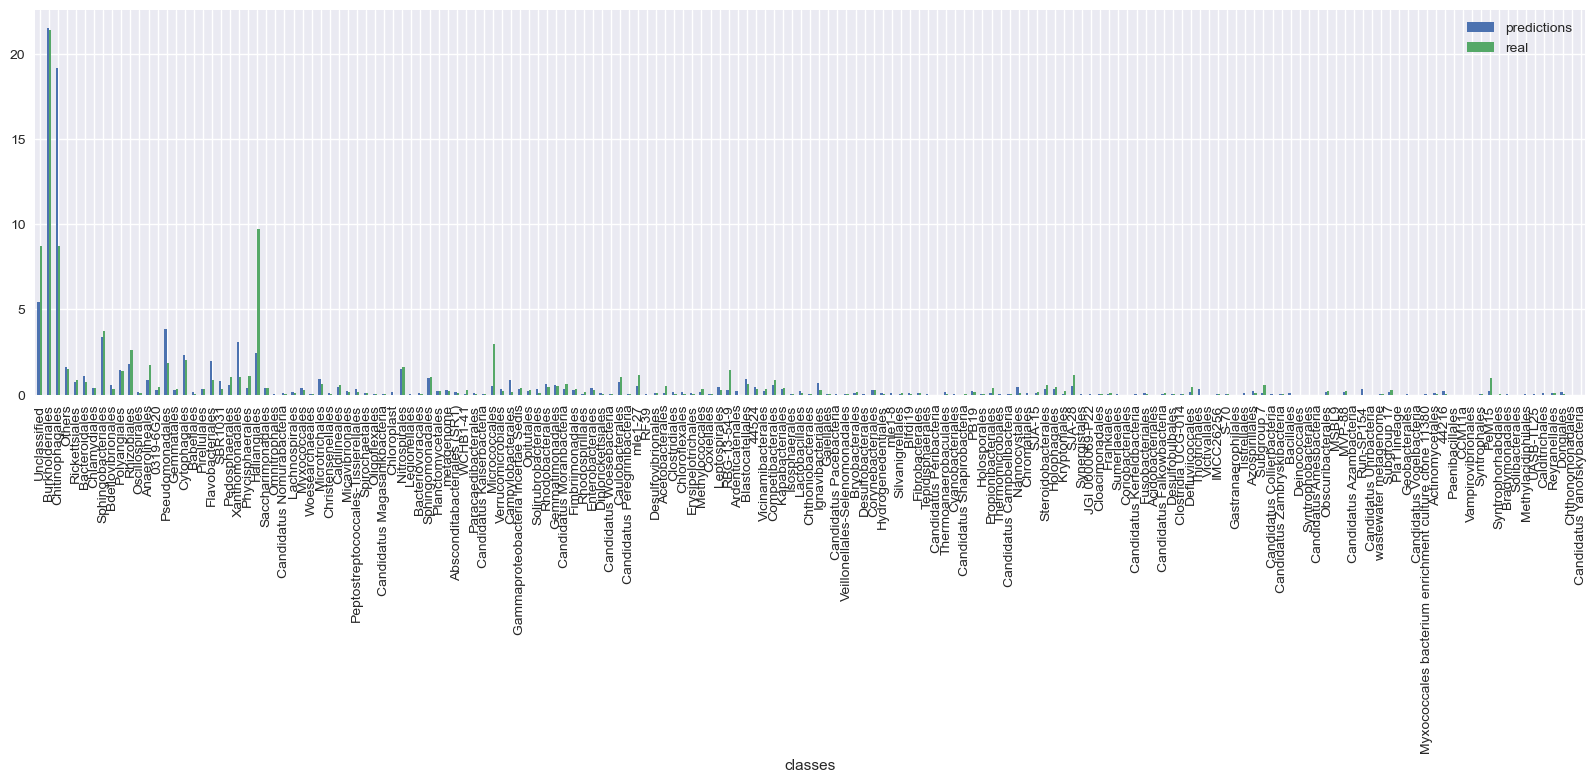

In [32]:
com.plot(kind='bar',figsize=(20,5));

预测和实际结果的散点图对比。

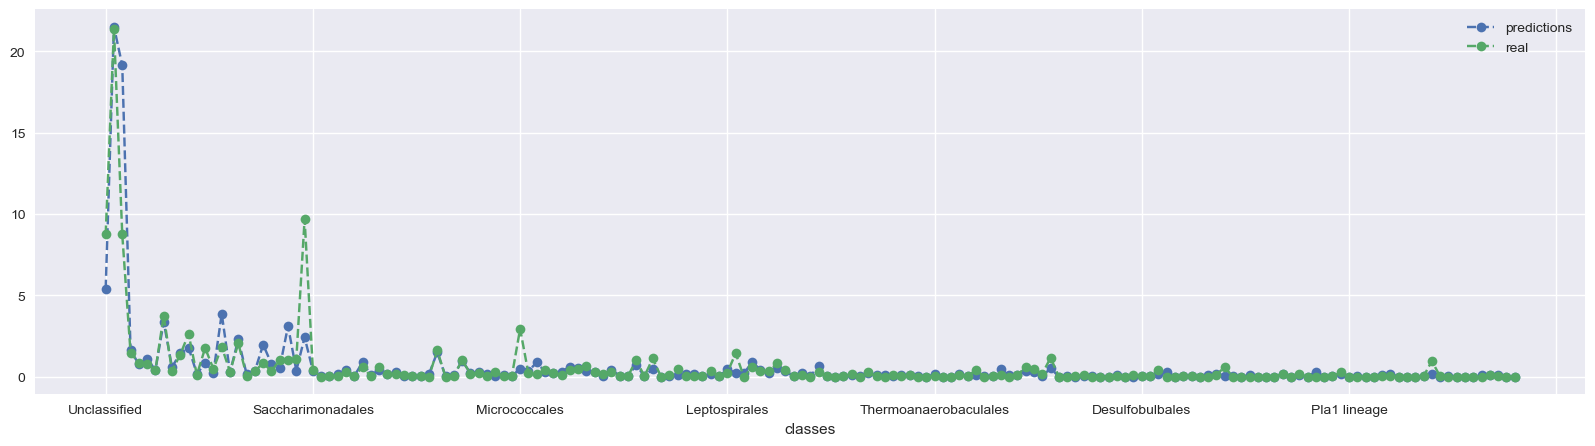

In [33]:
com.plot(kind='line',style='--o',figsize=(20,5));

上面是第一个预测结果和实际结果的对比，修改参数可以对比其他列。也可以汇总对比均值。

**模型评估**

训练集部分

R^2

In [34]:
print(f'R^2 Train: {model.score(X_train, y_train):0.4}')

R^2 Train: 0.06897


In [35]:
from sklearn import metrics

训练集的MSE

In [36]:
y_preds2 = model.predict(X_train)
metrics.mean_squared_error(y_train, y_preds2)

1.3915683467211981

测试集部分

In [37]:
MSE = metrics.mean_squared_error(y_test, y_preds)
MSE

2.970189145951005

In [38]:
RMSE = metrics.mean_squared_error(y_test, y_preds)**0.5
RMSE

1.7234236698940295

In [39]:
MAE = metrics.mean_absolute_error(y_test, y_preds)
MAE

0.3816540638631339

In [40]:
MAPE = metrics.mean_absolute_percentage_error(y_test, y_preds)
MAPE

83038356575891.33

# 调参和优化

In [41]:
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV

In [42]:
# Cross-validation
tscv = TimeSeriesSplit(n_splits=5)

In [43]:
# Get parameters list
model.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('regressor',
   MultiOutputRegressor(estimator=SGDRegressor(alpha=0.01, l1_ratio=0.25,
                                               penalty='elasticnet', tol=0.0001)))],
 'verbose': False,
 'scaler': StandardScaler(),
 'regressor': MultiOutputRegressor(estimator=SGDRegressor(alpha=0.01, l1_ratio=0.25,
                                             penalty='elasticnet', tol=0.0001)),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'regressor__estimator__alpha': 0.01,
 'regressor__estimator__average': False,
 'regressor__estimator__early_stopping': False,
 'regressor__estimator__epsilon': 0.1,
 'regressor__estimator__eta0': 0.01,
 'regressor__estimator__fit_intercept': True,
 'regressor__estimator__l1_ratio': 0.25,
 'regressor__estimator__learning_rate': 'invscaling',
 'regressor__estimator__loss': 'squared_error',
 'regressor__estimator__max_iter': 1000,
 'regressor__estimator__n_iter_no_change':

In [44]:
# Perform Gridsearch and fit
param_grid = {"regressor__estimator__alpha": [0.001,0.01,0.1,1,10,100],
             "regressor__estimator__l1_ratio": [0.25,0.1,0.5,0.01,0.8]}

In [45]:
gs = GridSearchCV(model, param_grid, n_jobs=-1, cv=tscv, verbose=1)
gs.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('regressor',
                                        MultiOutputRegressor(estimator=SGDRegressor(alpha=0.01,
                                                                                    l1_ratio=0.25,
                                                                                    penalty='elasticnet',
                                                                                    tol=0.0001)))]),
             n_jobs=-1,
             param_grid={'regressor__estimator__alpha': [0.001, 0.01, 0.1, 1,
                                                         10, 100],
                         'regressor__estimator__l1_ratio': [0.25, 0.1, 0.5,
                                                            0.01, 0.8]},
             verbose=1)

In [46]:
# Best Estimator
gs.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor',
                 MultiOutputRegressor(estimator=SGDRegressor(alpha=10,
                                                             l1_ratio=0.1,
                                                             penalty='elasticnet',
                                                             tol=0.0001)))])

In [47]:
print(f'R^2 Train: {gs.score(X_train, y_train):0.4}')

R^2 Train: 0.0003178


R方有更小

In [48]:
y_preds1 = gs.predict(X_test)

In [49]:
MSE = metrics.mean_squared_error(y_test, y_preds1)
MSE

2.7539383253632126

MSE有更小

In [50]:
y_preds2 = gs.predict(X_train)
metrics.mean_squared_error(y_train, y_preds2)

1.5797578937269372

MSE在训练集和测试集上的区别不大